## Imports

In [1]:
import logging
import os
import random
import sys
from collections import deque
from operator import itemgetter

import gym_donkeycar
import gymnasium as gym
import imageio
import ipywidgets as widgets
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from IPython.display import display
from ipywidgets import HBox, VBox
from matplotlib import pyplot as plt
from PIL import Image
from ruamel.yaml import YAML
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm
from tensorboard import notebook
from tensorboard.backend.event_processing.event_accumulator import \
    EventAccumulator
from torch import distributions as dist
from torch.distributions import Categorical, Normal
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

import gym.spaces as gym_spaces
import gymnasium as gym  # overwrite OpenAI gym

# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="gymnasium.spaces.box") # module="gymnasium"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["IMAGEIO_IGNORE_WARNINGS"] = "True"

import stable_baselines3 as sb3
from gym_donkeycar.envs.donkey_env import DonkeyEnv
from gymnasium import spaces
from gymnasium.spaces import Box
from stable_baselines3 import A2C, PPO, SAC
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

from src.actor_critic_dreamer import ActorCriticDreamer
from src.actor_critic import ContinuousActorCritic
from src.blocks import CategoricalStraightThrough, ConvBlock
from src.categorical_vae import CategoricalVAE
from src.imagination_env import make_imagination_env
from src.mlp import MLP
from src.preprocessing import transform
from src.replay_buffer import ReplayBuffer
from src.rssm import RSSM
from src.utils import (load_config, make_env, save_image_and_reconstruction,
                       to_np, symlog, symexp, twohot_encode)
from src.vae import VAE

torch.cuda.empty_cache()
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load the config
config = load_config()
for key in config:
    locals()[key] = config[key]

## Create the environment

In [2]:
# env = make_env()

In [3]:
env = gym.make("Pendulum-v1")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=config["n_updates"])
env = gym.wrappers.TimeLimit(env, max_episode_steps=config["max_episode_steps"])
env = gym.wrappers.AutoResetWrapper(env)
env = gym.experimental.wrappers.RescaleActionV0(env, min_action=config["action_space_low"], max_action=config["action_space_high"])

In [16]:
# agent = ContinuousActorCritic()
agent = ActorCriticDreamer()


# agent.load_weights("weights/ContinuousActorCritic_0")

# vae = VAE()
# vae.optim = optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-6)

In [9]:
obs, _ = env.reset()
obs = torch.Tensor(obs).to(device)

In [10]:
torch.sum(ac.critic(obs))

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [11]:
# ac.get_loss(batch_rewards, batch_log_probs, batch_value_preds, last_value_pred, batch_entropies, batch_masks)

In [14]:
# Example usage:
test_return = torch.Tensor([0.8]).to(device)
encoded_target = twohot_encode(test_return)
buckets = torch.linspace(-15, 15, 255).to(device)

print("Encoded Target:", encoded_target)
print("Restored Target:", symexp(encoded_target @ buckets))

tensor([0.0234], device='cuda:0')
Encoded Target: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [264]:
returns = torch.rand(5).to(device)
encoded_targets = torch.stack([twohot_encode(r) for r in returns])

print(returns)
print(symexp(encoded_targets @ buckets))

tensor([0.0678, 0.7529, 0.1364, 0.2639, 0.4595], device='cuda:0')
tensor([0.0678, 0.7529, 0.1364, 0.2639, 0.4595], device='cuda:0')


In [17]:
agent.apply_critic(obs)

tensor(-0.1017, device='cuda:0', grad_fn=<MulBackward0>)

In [20]:
agent.critic(obs)

tensor([0.0030, 0.0017, 0.0029, 0.0022, 0.0043, 0.0072, 0.0068, 0.0036, 0.0054,
        0.0024, 0.0033, 0.0040, 0.0044, 0.0051, 0.0032, 0.0038, 0.0048, 0.0039,
        0.0023, 0.0038, 0.0026, 0.0050, 0.0023, 0.0025, 0.0054, 0.0052, 0.0034,
        0.0035, 0.0049, 0.0056, 0.0025, 0.0039, 0.0029, 0.0068, 0.0025, 0.0036,
        0.0071, 0.0040, 0.0026, 0.0043, 0.0040, 0.0050, 0.0063, 0.0034, 0.0036,
        0.0052, 0.0054, 0.0020, 0.0030, 0.0026, 0.0026, 0.0054, 0.0030, 0.0024,
        0.0037, 0.0080, 0.0063, 0.0042, 0.0034, 0.0023, 0.0028, 0.0033, 0.0050,
        0.0066, 0.0031, 0.0024, 0.0028, 0.0053, 0.0040, 0.0029, 0.0039, 0.0063,
        0.0018, 0.0058, 0.0030, 0.0042, 0.0041, 0.0038, 0.0034, 0.0033, 0.0022,
        0.0047, 0.0048, 0.0022, 0.0056, 0.0054, 0.0017, 0.0056, 0.0033, 0.0082,
        0.0040, 0.0071, 0.0072, 0.0027, 0.0035, 0.0033, 0.0029, 0.0046, 0.0037,
        0.0042, 0.0030, 0.0033, 0.0058, 0.0022, 0.0031, 0.0047, 0.0029, 0.0026,
        0.0050, 0.0033, 0.0038, 0.0018, 

In [21]:
critic_dist = agent.critic(obs)

In [22]:
[critic_dist for i in range(3)]

[tensor([0.0030, 0.0017, 0.0029, 0.0022, 0.0043, 0.0072, 0.0068, 0.0036, 0.0054,
         0.0024, 0.0033, 0.0040, 0.0044, 0.0051, 0.0032, 0.0038, 0.0048, 0.0039,
         0.0023, 0.0038, 0.0026, 0.0050, 0.0023, 0.0025, 0.0054, 0.0052, 0.0034,
         0.0035, 0.0049, 0.0056, 0.0025, 0.0039, 0.0029, 0.0068, 0.0025, 0.0036,
         0.0071, 0.0040, 0.0026, 0.0043, 0.0040, 0.0050, 0.0063, 0.0034, 0.0036,
         0.0052, 0.0054, 0.0020, 0.0030, 0.0026, 0.0026, 0.0054, 0.0030, 0.0024,
         0.0037, 0.0080, 0.0063, 0.0042, 0.0034, 0.0023, 0.0028, 0.0033, 0.0050,
         0.0066, 0.0031, 0.0024, 0.0028, 0.0053, 0.0040, 0.0029, 0.0039, 0.0063,
         0.0018, 0.0058, 0.0030, 0.0042, 0.0041, 0.0038, 0.0034, 0.0033, 0.0022,
         0.0047, 0.0048, 0.0022, 0.0056, 0.0054, 0.0017, 0.0056, 0.0033, 0.0082,
         0.0040, 0.0071, 0.0072, 0.0027, 0.0035, 0.0033, 0.0029, 0.0046, 0.0037,
         0.0042, 0.0030, 0.0033, 0.0058, 0.0022, 0.0031, 0.0047, 0.0029, 0.0026,
         0.0050, 0.0033, 0.0

In [18]:
# losses = []
# 
# for i in tqdm(range(3000)):
#     obs = torch.rand(3).to(device)
#     
#     # prediction
#     prediction = ac.critic(obs) # (255,)
# 
#     # label
#     test_return = torch.mean(obs * 100)  # torch.Tensor([-100]).to(device)
#     encoded_target = twohot_encode(test_return, buckets).detach() # (255,)
# 
#     # update critic
#     critic_loss = - encoded_target @ torch.log(prediction)
#     ac.critic_optim.zero_grad()
#     critic_loss.backward(retain_graph=True)
#     nn.utils.clip_grad_norm_(ac.critic.parameters(), max_norm=ac.max_grad_norm, norm_type=2)
#     ac.critic_optim.step()
#     
#     losses.append(to_np(critic_loss))

In [19]:
# plt.plot(losses)

In [243]:
obs = torch.rand(3).to(device)
print("target:", torch.mean(obs * 100))
print("prediction:", apply_critic(ac, obs))

target: tensor(29.3070, device='cuda:0')
prediction: tensor(28.7844, device='cuda:0', grad_fn=<MulBackward0>)


In [170]:
# manual crossentropy loss for one t: (sum over elements in batch)
# - encoded_target @ torch.log(prediction)

In [31]:
# New training loop with batches

losses = {
    "critic_loss": [],
    "actor_loss": [],
}

# Logging
writer = SummaryWriter(log_dir)
if config["show_inline_tensorboard"]:
    notebook.start(f"--logdir={log_dir}")

for sample_phase in tqdm(range(n_updates)):
    
    batch_observations = []
    
    # NEW
    batch_rewards = []
    batch_log_probs = []
    batch_value_preds = []
    batch_entropies = []
    batch_masks = []
    batch_critic_dists = []
    
    if sample_phase == 0:
        obs, info = env.reset(seed=42)
        obs = torch.Tensor(obs).to(device) ### Pendulum
        # obs = transform(obs)
        # if len(obs.shape) == 4:
        #     obs = obs[0]
        # z, reconstruction, mu, logvar = vae(obs)

    for step in range(n_steps_per_update):
            
        # Add the observation, reconstruction, mu, and logvar to the respective batches
        batch_observations.append(obs)
        value_pred, critic_dist = agent.apply_critic(obs) # obs for Pendulum | z for VAE

        # Get an action and take an environment step
        action, log_prob, actor_entropy = agent.get_action(obs) ### obs for Pendulum | z for VAE
        obs, reward, terminated, truncated, info = env.step(to_np(action))
        
        # Transform the next obs
        obs = torch.Tensor(obs).to(device) ### Pendulum
        # obs = transform(obs)
        # if len(obs.shape) == 4:
        #     obs = obs[0]
        # z, reconstruction, mu, logvar = vae(obs)
        
        # Collect the necessary data for an agent update
        batch_rewards.append(reward)
        batch_log_probs.append(log_prob)
        batch_entropies.append(actor_entropy)
        mask = torch.tensor(0.0 if terminated else 1.0)
        batch_masks.append(mask)
        batch_value_preds.append(value_pred)
        batch_critic_dists.append(critic_dist)

    # Convert the batch tensors to tensors
    batch_observations = torch.stack(batch_observations).to(device)  # [n_steps_per_update, *obs_shape]
    batch_rewards = torch.tensor(batch_rewards).to(device)  # [n_steps_per_update]
    batch_log_probs = torch.stack(batch_log_probs).to(device)  # [n_steps_per_update]
    batch_value_preds = torch.stack(batch_value_preds).to(device)  # [n_steps_per_update]
    batch_entropies = torch.stack(batch_entropies).to(device)  # [n_steps_per_update]
    batch_masks = torch.stack(batch_masks).to(device)  # [n_steps_per_update]
    batch_critic_dists = torch.stack(batch_critic_dists).to(device)
    last_value_pred, last_critic_dist = agent.apply_critic(obs) # last value prediction for GAE

    # Update the agent's parameters
    critic_loss, actor_loss = agent.get_loss(
        batch_rewards, batch_log_probs, batch_value_preds, batch_critic_dists, 
        last_value_pred, last_critic_dist, batch_entropies, batch_masks
    )
    agent.update_parameters(critic_loss, actor_loss)
    
    # Update the VAE's parameters
    # vae_loss, reconstruction_loss, kld_loss = vae.get_loss(batch_, x_hat, mu, logvar)
    # vae.optim.zero_grad()
    # vae_loss.backward()
    # vae.optim.step()    

    if sample_phase % config["log_interval"] == 0:
        
        # Log the losses
        losses["critic_loss"].append(to_np(critic_loss))
        losses["actor_loss"].append(to_np(actor_loss))

        # Log the episode metrics
        if len(env.return_queue):
            writer.add_scalar("episode_return", np.array(env.return_queue)[-1:], global_step=len(env.return_queue))
        writer.add_scalar("critic_loss", to_np(critic_loss), global_step=sample_phase)
        writer.add_scalar("actor_loss", to_np(actor_loss), global_step=sample_phase)


  0%|                                                                                        | 10/31250 [00:00<11:24, 45.63it/s]

17
16
tensor([-71.2650, -72.1046, -72.8724, -73.2958, -72.9275, -71.3062, -68.1155,
        -63.2460, -56.2479, -47.1091, -37.0151, -28.1370, -20.3113, -13.5952,
         -8.2612,  -3.9092,  -0.2242], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.2803, -4.2919, -4.3023, -4.3081, -4.3031, -4.2809, -4.2358, -4.1627,
        -4.0474, -3.8735, -3.6380, -3.3720, -3.0592, -2.6807, -2.2258, -1.5911,
        -0.2023], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-63.1498, -63.3805, -64.1512, -65.1212, -66.0722, -66.6428, -66.6766,
        -65.7893, -63.3973, -59.4713, -53.6479, -45.4657, -34.4881, -23.8209,
        -14.3610,  -6.3474,   0.3749], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.1612, -4.1648, -4.1767, -4.1915, -4.2058, -4.2142, -4.2147, -4.2015,
        -4.1651, -4.1022, -4.0009, -3.8387, -3.5692, -3.2117, -2.7318, -1.9943,
         0.3184], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  0%|                                                                                        | 20/31250 [00:00<11:10, 46.59it/s]

17
16
tensor([-95.9897, -92.6424, -88.5190, -83.7272, -77.9948, -71.4417, -64.9832,
        -58.6405, -52.3807, -46.2231, -40.1601, -34.2068, -28.3531, -22.5016,
        -16.5194, -10.2591,  -3.5201], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.5746, -4.5395, -4.4945, -4.4394, -4.3694, -4.2828, -4.1894, -4.0883,
        -3.9775, -3.8549, -3.7175, -3.5612, -3.3794, -3.1571, -2.8633, -2.4212,
        -1.5085], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-94.8230, -92.4256, -89.5105, -86.0352, -81.8535, -76.7295, -70.6890,
        -63.6110, -56.7880, -50.1700, -43.6428, -37.1103, -30.5762, -24.0415,
        -17.4371, -10.5329,  -3.1384], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.5625, -4.5372, -4.5055, -4.4663, -4.4171, -4.3532, -4.2723, -4.1684,
        -4.0568, -3.9352, -3.7987, -3.6405, -3.4524, -3.2205, -2.9144, -2.4452,
        -1.4203], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  0%|                                                                                        | 25/31250 [00:00<11:15, 46.23it/s]

17
16
tensor([-82.1867, -78.9054, -73.9489, -66.7935, -57.6847, -49.2455, -42.0477,
        -35.7294, -30.3801, -25.8252, -21.9033, -18.6647, -15.7936, -13.0341,
        -10.1673,  -6.9417,  -2.9766], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.4211, -4.3808, -4.3168, -4.2165, -4.0722, -3.9169, -3.7623, -3.6036,
        -3.4462, -3.2893, -3.1313, -2.9788, -2.8210, -2.6415, -2.4130, -2.0721,
        -1.3804], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-81.3092, -80.5545, -78.3634, -74.3625, -68.2633, -59.9601, -50.1839,
        -41.5489, -34.3114, -28.1529, -23.2575, -19.2761, -15.9553, -13.0132,
        -10.2966,  -7.5143,  -4.3570], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.4105, -4.4013, -4.3740, -4.3223, -4.2379, -4.1102, -3.9354, -3.7507,
        -3.5642, -3.3726, -3.1887, -3.0094, -2.8306, -2.6400, -2.4245, -2.1417,
        -1.6784], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  0%|                                                                                        | 40/31250 [00:00<11:01, 47.20it/s]

17
16
tensor([-101.5862,  -97.8132,  -94.1488,  -90.5315,  -86.8280,  -82.8662,
         -78.4622,  -73.4854,  -67.9637,  -61.8152,  -55.0139,  -47.6347,
         -39.6747,  -31.3112,  -22.6220,  -13.5571,   -4.1385],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6307, -4.5932, -4.5554, -4.5167, -4.4754, -4.4292, -4.3753, -4.3106,
        -4.2336, -4.1402, -4.0256, -3.8843, -3.7056, -3.4754, -3.1622, -2.6781,
        -1.6368], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-105.3589, -101.2015,  -96.9396,  -92.4840,  -87.8314,  -82.9085,
         -77.7223,  -72.2018,  -66.2501,  -59.7883,  -52.8322,  -45.2235,
         -37.2024,  -29.0282,  -20.7058,  -12.1896,   -3.3875],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6668, -4.6269, -4.5844, -4.5378, -4.4867, -4.4297, -4.3659, -4.2932,
        -4.2084, -4.1074, -3.9859, -3.8335, -3.6429, -3.4021, -3.0776, -2.5794,
        -1.4788], device='cuda:0', gr

  0%|▏                                                                                       | 45/31250 [00:00<10:49, 48.03it/s]

17
16
tensor([-94.4255, -89.9971, -84.2569, -77.7588, -71.7434, -66.3220, -61.3458,
        -56.6528, -52.1686, -47.7705, -43.2962, -38.5521, -33.3724, -27.5047,
        -20.6987, -13.0128,  -4.3932], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.5583, -4.5108, -4.4457, -4.3664, -4.2869, -4.2095, -4.1327, -4.0544,
        -3.9735, -3.8871, -3.7909, -3.6776, -3.5373, -3.3501, -3.0773, -2.6400,
        -1.6851], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-93.1700, -88.2316, -82.3626, -76.3098, -70.5706, -65.1581, -60.0736,
        -55.3510, -50.8837, -46.5121, -41.9814, -37.0436, -31.6557, -25.7504,
        -19.2793, -12.0812,  -3.8960], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.5451, -4.4912, -4.4232, -4.3478, -4.2707, -4.1920, -4.1121, -4.0316,
        -3.9490, -3.8610, -3.7608, -3.6387, -3.4860, -3.2866, -3.0096, -2.5712,
        -1.5884], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  0%|▏                                                                                       | 56/31250 [00:01<10:36, 48.98it/s]

17
16
tensor([-93.8890, -91.6123, -88.8998, -85.6190, -81.6923, -76.8033, -70.7018,
        -63.5374, -56.5002, -49.8760, -43.5306, -37.3345, -31.1334, -24.7887,
        -18.0594, -10.8813,  -3.1702], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.5527, -4.5284, -4.4987, -4.4615, -4.4151, -4.3542, -4.2725, -4.1672,
        -4.0518, -3.9294, -3.7962, -3.6463, -3.4699, -3.2499, -2.9476, -2.4750,
        -1.4280], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-101.7390,  -98.8865,  -95.5692,  -91.6325,  -87.1194,  -82.0588,
         -76.3910,  -70.2033,  -63.5286,  -56.6917,  -49.6995,  -42.5516,
         -35.2154,  -27.6488,  -19.8342,  -11.7721,   -3.3595],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6322, -4.6040, -4.5703, -4.5286, -4.4787, -4.4195, -4.3489, -4.2655,
        -4.1671, -4.0551, -3.9259, -3.7739, -3.5895, -3.3551, -3.0366, -2.5473,
        -1.4724], device='cuda:0', grad_fn=<MulBackward0>)
re

  0%|▏                                                                                       | 68/31250 [00:01<10:22, 50.09it/s]

17
16
tensor([-69.9968, -63.9052, -57.6363, -51.1197, -44.3137, -37.1375, -29.4630,
        -21.3096, -12.6642, -12.4097, -12.2278, -11.9146, -11.3216, -10.4172,
         -8.9706,  -6.8129,  -3.6368], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.2626, -4.1729, -4.0714, -3.9535, -3.8136, -3.6412, -3.4165, -3.1050,
        -2.6148, -2.5960, -2.5823, -2.5584, -2.5114, -2.4351, -2.2996, -2.0558,
        -1.5340], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-85.2387, -85.0564, -82.9391, -78.2290, -70.5022, -59.7131, -47.6804,
        -37.1850, -28.6322, -21.9281, -16.7197, -12.7609,  -9.6417,  -7.4164,
         -5.8263,  -4.7010,  -3.8704], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.4571, -4.4550, -4.4301, -4.3723, -4.2697, -4.1062, -3.8853, -3.6424,
        -3.3889, -3.1324, -2.8747, -2.6218, -2.3648, -2.1302, -1.9208, -1.7406,
        -1.5832], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  0%|▏                                                                                       | 80/31250 [00:01<10:23, 50.01it/s]

17
16
tensor([-67.5361, -65.5638, -64.4173, -64.0757, -64.1571, -64.4503, -64.6066,
        -64.2829, -63.2207, -60.9723, -57.2909, -51.9410, -44.2123, -33.9007,
        -22.7916, -12.8870,  -4.3324], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.2274, -4.1982, -4.1808, -4.1756, -4.1768, -4.1813, -4.1837, -4.1787,
        -4.1623, -4.1267, -4.0654, -3.9692, -3.8114, -3.5525, -3.1693, -2.6310,
        -1.6738], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-74.5113, -70.8551, -68.4939, -67.1474, -66.4518, -66.0824, -65.6682,
        -65.0204, -63.7110, -61.2866, -57.3010, -51.4698, -43.4715, -33.0151,
        -22.6709, -13.1955,  -4.7327], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.3243, -4.2747, -4.2412, -4.2217, -4.2114, -4.2059, -4.1997, -4.1900,
        -4.1699, -4.1317, -4.0656, -3.9602, -3.7948, -3.5268, -3.1642, -2.6529,
        -1.7462], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  0%|▎                                                                                       | 90/31250 [00:01<10:37, 48.87it/s]

17
16
tensor([-75.4296, -78.1021, -80.4868, -82.2085, -82.8472, -81.8336, -78.8907,
        -73.4282, -64.7965, -52.7462, -40.3237, -30.0305, -21.7675, -15.2105,
         -9.8968,  -5.8125,  -2.7934], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.3364, -4.3707, -4.4004, -4.4213, -4.4290, -4.4168, -4.3807, -4.3098,
        -4.1866, -3.9843, -3.7214, -3.4350, -3.1253, -2.7857, -2.3885, -1.9188,
        -1.3333], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-15.1604, -13.6132, -12.7587, -12.3405, -12.2021, -12.2707, -12.4888,
        -12.7899, -13.1063, -13.3891, -13.5929, -13.6735, -13.4413, -12.7685,
        -11.3241,  -8.9287,  -5.0052], device='cuda:0', grad_fn=<CopySlices>)
tensor([-2.7826, -2.6819, -2.6217, -2.5908, -2.5804, -2.5856, -2.6019, -2.6239,
        -2.6466, -2.6665, -2.6805, -2.6860, -2.6701, -2.6224, -2.5116, -2.2954,
        -1.7926], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  0%|▎                                                                                      | 101/31250 [00:02<10:28, 49.54it/s]

17
16
tensor([-79.7999, -77.4560, -75.5717, -74.1051, -72.8260, -71.3850, -69.4143,
        -66.8374, -63.2237, -58.3254, -51.8131, -43.5400, -33.9967, -25.3097,
        -17.4035, -10.1156,  -3.3453], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.3920, -4.3625, -4.3382, -4.3189, -4.3017, -4.2820, -4.2544, -4.2171,
        -4.1624, -4.0830, -3.9668, -3.7964, -3.5553, -3.2699, -2.9125, -2.4083,
        -1.4691], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-75.0009, -72.7346, -71.0798, -69.9031, -68.9144, -67.7921, -66.3742,
        -64.4931, -61.9869, -58.6052, -53.8950, -47.4420, -39.3439, -29.6001,
        -20.2244, -11.5639,  -3.5021], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.3307, -4.3005, -4.2778, -4.2613, -4.2473, -4.2311, -4.2103, -4.1819,
        -4.1429, -4.0877, -4.0054, -3.8804, -3.6974, -3.4210, -3.0552, -2.5308,
        -1.5046], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  0%|▎                                                                                      | 112/31250 [00:02<10:21, 50.08it/s]

17
16
tensor([-67.2943, -69.6469, -71.8138, -73.6442, -74.9855, -75.4750, -74.4243,
        -71.9048, -67.5083, -60.6279, -51.1697, -39.3457, -29.1067, -20.3479,
        -13.0236,  -7.0770,  -2.2345], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.2238, -4.2577, -4.2879, -4.3127, -4.3305, -4.3370, -4.3231, -4.2892,
        -4.2270, -4.1211, -3.9545, -3.6975, -3.4047, -3.0610, -2.6407, -2.0890,
        -1.1739], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-62.8753, -62.3049, -62.4643, -63.0568, -63.7852, -64.3056, -64.4505,
        -63.7689, -62.1671, -59.4254, -55.3848, -49.3316, -41.4545, -31.7469,
        -21.1378, -11.6226,  -3.1642], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.1569, -4.1480, -4.1505, -4.1598, -4.1711, -4.1791, -4.1813, -4.1708,
        -4.1458, -4.1014, -4.0322, -3.9186, -3.7484, -3.4888, -3.0973, -2.5355,
        -1.4265], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  0%|▎                                                                                      | 124/31250 [00:02<10:17, 50.41it/s]

17
16
tensor([-98.1633, -93.6263, -89.3448, -85.2213, -81.2359, -77.3113, -73.3042,
        -68.9919, -64.2396, -59.0635, -53.1978, -46.7072, -39.3282, -30.9410,
        -21.9415, -12.9792,  -4.1336], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.5968, -4.5499, -4.5036, -4.4569, -4.4096, -4.3607, -4.3082, -4.2484,
        -4.1781, -4.0954, -3.9926, -3.8651, -3.6971, -3.4639, -3.1329, -2.6376,
        -1.6358], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-96.7734, -93.1743, -89.7827, -86.5817, -83.3698, -79.9436, -76.0940,
        -71.5918, -66.4468, -60.3396, -53.3759, -45.6258, -37.6364, -29.5503,
        -21.3015, -12.8392,  -4.0065], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.5827, -4.5451, -4.5085, -4.4726, -4.4352, -4.3938, -4.3450, -4.2849,
        -4.2113, -4.1164, -3.9959, -3.8422, -3.6542, -3.4194, -3.1047, -2.6275,
        -1.6107], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  0%|▍                                                                                      | 136/31250 [00:02<10:24, 49.85it/s]

17
16
tensor([-71.0847, -70.8199, -70.9072, -71.0678, -70.9898, -70.5094, -69.4004,
        -67.5426, -64.7864, -60.4668, -54.3424, -46.6313, -37.2514, -27.7080,
        -19.1459, -11.2780,  -4.3123], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.2778, -4.2742, -4.2754, -4.2776, -4.2765, -4.2698, -4.2542, -4.2275,
        -4.1864, -4.1185, -4.0135, -3.8635, -3.6442, -3.3572, -3.0030, -2.5078,
        -1.6700], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-77.4905, -75.2080, -73.5370, -72.3811, -71.5135, -70.5870, -69.3050,
        -67.2923, -64.1404, -59.7061, -53.5246, -45.5377, -35.7729, -26.7476,
        -18.3861, -10.7870,  -3.9111], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.3630, -4.3335, -4.3113, -4.2957, -4.2838, -4.2709, -4.2528, -4.2238,
        -4.1765, -4.1060, -3.9987, -3.8403, -3.6048, -3.3231, -2.9646, -2.4670,
        -1.5915], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  0%|▍                                                                                      | 142/31250 [00:02<10:22, 50.01it/s]

17
16
tensor([-102.4084,  -98.3020,  -94.1359,  -89.8149,  -85.2285,  -80.4009,
         -75.3365,  -69.9910,  -64.2821,  -58.1738,  -51.7032,  -44.8937,
         -37.7335,  -30.1575,  -22.0954,  -13.4329,   -4.0568],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6387, -4.5982, -4.5553, -4.5088, -4.4570, -4.3994, -4.3352, -4.2626,
        -4.1787, -4.0805, -3.9647, -3.8263, -3.6567, -3.4391, -3.1396, -2.6695,
        -1.6207], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-109.3406, -105.2119, -100.6823,  -95.8105,  -90.6450,  -85.0663,
         -79.1945,  -73.0650,  -66.7281,  -60.9421,  -54.4274,  -47.1717,
         -39.2362,  -30.8365,  -22.2077,  -13.3102,   -4.0780],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.7036, -4.6654, -4.6219, -4.5728, -4.5179, -4.4551, -4.3845, -4.3049,
        -4.2155, -4.1262, -4.0151, -3.8748, -3.6948, -3.4606, -3.1445, -2.6610,
        -1.6249], device='cuda:0', gr

  0%|▍                                                                                      | 154/31250 [00:03<10:28, 49.48it/s]

17
16
tensor([-104.0071,  -99.2869,  -94.6384,  -90.0572,  -85.4021,  -80.5779,
         -75.5304,  -70.2748,  -64.7550,  -58.9941,  -52.8824,  -46.2769,
         -39.0780,  -31.2313,  -22.7927,  -13.7465,   -4.1195],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6540, -4.6080, -4.5606, -4.5115, -4.4590, -4.4016, -4.3377, -4.2665,
        -4.1859, -4.0942, -3.9868, -3.8560, -3.6908, -3.4729, -3.1694, -2.6910,
        -1.6331], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-109.4966, -105.1034, -100.3182,  -95.4619,  -90.5125,  -85.3969,
         -80.0064,  -74.2906,  -68.1805,  -61.5481,  -54.3318,  -46.8443,
         -39.1077,  -31.0436,  -22.5800,  -13.5893,   -4.1267],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.7050, -4.6644, -4.6183, -4.5691, -4.5165, -4.4590, -4.3945, -4.3214,
        -4.2367, -4.1359, -4.0133, -3.8680, -3.6916, -3.4671, -3.1604, -2.6803,
        -1.6345], device='cuda:0', gr

  1%|▍                                                                                      | 165/31250 [00:03<10:20, 50.12it/s]

17
16
tensor([-97.1050, -94.0898, -90.8080, -87.2482, -83.4123, -79.1656, -74.3233,
        -68.7940, -62.5860, -55.4633, -47.9300, -40.5351, -33.3256, -26.2721,
        -19.2068, -11.9181,  -4.2163], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.5860, -4.5548, -4.5197, -4.4802, -4.4357, -4.3841, -4.3218, -4.2455,
        -4.1524, -4.0336, -3.8904, -3.7265, -3.5359, -3.3059, -3.0060, -2.5586,
        -1.6518], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-96.1025, -93.0811, -89.7017, -85.9236, -81.5889, -76.5479, -70.5640,
        -63.5673, -56.6445, -49.9642, -43.4571, -37.0498, -30.7428, -24.5077,
        -18.1409, -11.4209,  -4.0726], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.5758, -4.5442, -4.5076, -4.4650, -4.4139, -4.3509, -4.2706, -4.1677,
        -4.0543, -3.9311, -3.7945, -3.6389, -3.4577, -3.2390, -2.9518, -2.5194,
        -1.6239], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  1%|▍                                                                                      | 177/31250 [00:03<10:15, 50.47it/s]

17
16
tensor([-91.9364, -86.3080, -81.2076, -76.5405, -72.2608, -68.1881, -64.3139,
        -60.4700, -56.5284, -52.2933, -47.7271, -42.6070, -36.8000, -30.1332,
        -22.4238, -13.7396,  -4.0270], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.5319, -4.4694, -4.4092, -4.3508, -4.2940, -4.2368, -4.1792, -4.1185,
        -4.0523, -3.9758, -3.8862, -3.7752, -3.6323, -3.4383, -3.1538, -2.6905,
        -1.6148], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-101.7974,  -96.6157,  -91.6391,  -86.8210,  -82.1345,  -77.5059,
         -72.7632,  -67.8602,  -62.8042,  -57.4788,  -51.6895,  -45.2874,
         -38.3126,  -30.7881,  -22.5153,  -13.6024,   -4.0718],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6328, -4.5810, -4.5287, -4.4753, -4.4205, -4.3632, -4.3009, -4.2321,
        -4.1558, -4.0687, -3.9644, -3.8349, -3.6715, -3.4591, -3.1577, -2.6812,
        -1.6237], device='cuda:0', grad_fn=<MulBackward0>)
re

  1%|▌                                                                                      | 189/31250 [00:03<10:17, 50.30it/s]

17
16
tensor([-108.8067, -104.8201, -100.6071,  -96.2012,  -91.5851,  -86.6511,
         -81.2644,  -75.3134,  -68.9098,  -62.1354,  -55.0602,  -47.7000,
         -40.0097,  -31.8904,  -23.2044,  -13.8393,   -4.1368],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6987, -4.6617, -4.6211, -4.5768, -4.5281, -4.4734, -4.4099, -4.3348,
        -4.2472, -4.1453, -4.0264, -3.8857, -3.7138, -3.4932, -3.1865, -2.6973,
        -1.6364], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-104.8388, -100.3978,  -95.9219,  -91.3672,  -86.7181,  -81.9706,
         -77.0604,  -71.8389,  -66.2224,  -60.2037,  -53.7304,  -46.7422,
         -39.2919,  -31.3390,  -22.8918,  -13.8222,   -4.1041],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6619, -4.6191, -4.5739, -4.5258, -4.4741, -4.4185, -4.3575, -4.2882,
        -4.2080, -4.1142, -4.0024, -3.8658, -3.6962, -3.4763, -3.1735, -2.6961,
        -1.6300], device='cuda:0', gr

  1%|▌                                                                                      | 195/31250 [00:03<10:31, 49.21it/s]

tensor([-4.5256, -4.4819, -4.4202, -4.3311, -4.2292, -4.1311, -4.0389, -3.9521,
        -3.8684, -3.7832, -3.6894, -3.5800, -3.4447, -3.2635, -3.0056, -2.5790,
        -1.6176], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-95.4737, -91.0999, -85.7820, -79.2381, -73.2301, -67.6259, -62.4128,
        -57.4952, -52.7851, -48.1673, -43.4592, -38.4818, -33.1185, -27.0954,
        -20.2551, -12.5859,  -4.0042], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.5693, -4.5229, -4.4634, -4.3850, -4.3072, -4.2287, -4.1497, -4.0689,
        -3.9850, -3.8952, -3.7946, -3.6758, -3.5298, -3.3356, -3.0566, -2.6090,
        -1.6103], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-105.1687, -101.1128,  -96.3698,  -90.8439,  -85.5616,  -80.4310,
         -75.3643,  -70.2372,  -64.9340,  -59.3017,  -53.2726,  -46.6683,
         -39.3155,  -31.0764,  -22.0747,  -13.0433,   -3

  1%|▌                                                                                      | 205/31250 [00:04<10:32, 49.08it/s]

17
16
tensor([-102.7252,  -98.1420,  -93.5469,  -88.9527,  -84.3358,  -79.6644,
         -74.8761,  -69.8277,  -64.4484,  -58.6107,  -52.3647,  -45.7030,
         -38.5334,  -30.6926,  -22.2796,  -13.3305,   -3.8648],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6417, -4.5966, -4.5491, -4.4993, -4.4466, -4.3903, -4.3291, -4.2603,
        -4.1813, -4.0878, -3.9772, -3.8438, -3.6771, -3.4561, -3.1476, -2.6624,
        -1.5820], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-68.0340, -70.3520, -72.5542, -74.5207, -75.8678, -76.1104, -75.2921,
        -72.9167, -68.7094, -62.4450, -54.0193, -42.6645, -31.8306, -22.7378,
        -15.2085,  -9.1371,  -3.9377], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.2346, -4.2676, -4.2980, -4.3244, -4.3421, -4.3452, -4.3346, -4.3029,
        -4.2443, -4.1502, -4.0077, -3.7765, -3.4914, -3.1671, -2.7855, -2.3162,
        -1.5969], device='cuda:0', grad_fn=<MulBackward0>)
re

  1%|▌                                                                                      | 216/31250 [00:04<10:26, 49.52it/s]

17
16
tensor([-105.4967, -101.5697,  -97.4884,  -93.2039,  -88.6796,  -83.7731,
         -78.5451,  -72.9148,  -66.9496,  -60.6957,  -54.1326,  -47.1250,
         -39.6942,  -31.7040,  -23.1772,  -13.9479,   -4.0800],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6681, -4.6305, -4.5899, -4.5455, -4.4962, -4.4400, -4.3763, -4.3029,
        -4.2188, -4.1222, -4.0097, -3.8738, -3.7061, -3.4875, -3.1854, -2.7046,
        -1.6253], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-106.1456, -101.5101,  -96.6395,  -91.5771,  -86.3816,  -81.0335,
         -75.5450,  -69.8393,  -63.8453,  -57.5995,  -51.1151,  -44.3592,
         -37.2014,  -29.6598,  -21.6932,  -13.2244,   -4.1402],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6742, -4.6300, -4.5813, -4.5280, -4.4703, -4.4071, -4.3379, -4.2604,
        -4.1720, -4.0707, -3.9535, -3.8146, -3.6429, -3.4230, -3.1221, -2.6550,
        -1.6371], device='cuda:0', gr

  1%|▋                                                                                      | 226/31250 [00:04<10:40, 48.45it/s]

17
16
tensor([-110.6462, -106.3568, -101.6935,  -96.7912,  -91.6605,  -86.1812,
         -80.3797,  -74.3750,  -68.1052,  -61.4721,  -54.3640,  -46.8467,
         -38.9722,  -30.7248,  -22.1459,  -13.2712,   -4.0313],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.7153, -4.6762, -4.6317, -4.5828, -4.5289, -4.4680, -4.3991, -4.3225,
        -4.2356, -4.1347, -4.0139, -3.8680, -3.6882, -3.4571, -3.1418, -2.6582,
        -1.6157], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-106.4864, -102.5070,  -98.2461,  -93.6503,  -88.6877,  -83.4070,
         -77.6493,  -71.4915,  -64.8379,  -57.9623,  -50.8889,  -43.6663,
         -36.3162,  -28.7797,  -20.9672,  -12.7553,   -4.0414],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6774, -4.6396, -4.5976, -4.5502, -4.4963, -4.4356, -4.3650, -4.2835,
        -4.1872, -4.0769, -3.9491, -3.7992, -3.6194, -3.3938, -3.0896, -2.6214,
        -1.6177], device='cuda:0', gr

  1%|▋                                                                                      | 236/31250 [00:04<10:43, 48.19it/s]

17
16
tensor([-107.4590, -102.8302,  -98.0893,  -93.2028,  -88.1849,  -82.9874,
         -77.5691,  -71.8166,  -65.7339,  -59.3256,  -52.6299,  -45.5753,
         -38.1912,  -30.4535,  -22.2370,  -13.4565,   -4.0863],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6864, -4.6428, -4.5960, -4.5455, -4.4907, -4.4307, -4.3640, -4.2879,
        -4.2007, -4.0998, -3.9821, -3.8411, -3.6685, -3.4485, -3.1457, -2.6711,
        -1.6266], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-103.8651,  -99.3061,  -94.2098,  -88.9724,  -83.7010,  -78.3903,
         -73.0377,  -67.5967,  -62.0649,  -56.4123,  -50.5003,  -44.1825,
         -37.3356,  -29.9864,  -22.1200,  -13.5374,   -4.0939],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6527, -4.6082, -4.5561, -4.4995, -4.4391, -4.3744, -4.3046, -4.2282,
        -4.1442, -4.0503, -3.9416, -3.8107, -3.6464, -3.4335, -3.1407, -2.6767,
        -1.6280], device='cuda:0', gr

  1%|▋                                                                                      | 247/31250 [00:05<10:34, 48.86it/s]

17
16
tensor([-95.2572, -92.4266, -88.5130, -83.4625, -77.2415, -70.2870, -63.9013,
        -58.0684, -52.5895, -47.4647, -42.4989, -37.4633, -32.0937, -26.1197,
        -19.5386, -12.2113,  -3.9826], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.5670, -4.5372, -4.4944, -4.4363, -4.3598, -4.2667, -4.1729, -4.0787,
        -3.9814, -3.8808, -3.7727, -3.6497, -3.4993, -3.3003, -3.0223, -2.5811,
        -1.6059], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-99.6033, -95.7121, -91.0109, -85.4890, -79.5288, -73.8462, -68.3247,
        -62.8806, -57.4948, -52.0191, -46.3972, -40.5517, -34.4022, -27.7589,
        -20.5672, -12.7098,  -4.0795], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6112, -4.5717, -4.5219, -4.4600, -4.3886, -4.3154, -4.2388, -4.1570,
        -4.0689, -3.9707, -3.8586, -3.7269, -3.5668, -3.3589, -3.0712, -2.6181,
        -1.6252], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  1%|▋                                                                                      | 257/31250 [00:05<10:36, 48.68it/s]

17
16
tensor([-104.3467, -100.0516,  -95.4350,  -90.5477,  -85.3602,  -79.8782,
         -74.1159,  -68.1336,  -61.9641,  -55.6232,  -49.0337,  -42.1962,
         -35.0127,  -27.4717,  -19.5986,  -11.2908,   -2.6361],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6573, -4.6156, -4.5689, -4.5169, -4.4585, -4.3929, -4.3190, -4.2360,
        -4.1426, -4.0364, -3.9127, -3.7658, -3.5839, -3.3489, -3.0252, -2.5088,
        -1.2909], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-30.6738, -32.0847, -33.6729, -35.3343, -36.9533, -38.4208, -39.7936,
        -40.8606, -41.4645, -41.4944, -40.7095, -38.9666, -35.9775, -31.2503,
        -24.5178, -15.5437,  -3.4068], device='cuda:0', grad_fn=<CopySlices>)
tensor([-3.4555, -3.4991, -3.5460, -3.5928, -3.6364, -3.6743, -3.7085, -3.7343,
        -3.7487, -3.7494, -3.7307, -3.6880, -3.6103, -3.4735, -3.2394, -2.8060,
        -1.4831], device='cuda:0', grad_fn=<MulBackward0>)
re

  1%|▋                                                                                      | 267/31250 [00:05<10:47, 47.87it/s]

17
16
tensor([-103.9903, -100.2268,  -96.2592,  -92.0572,  -87.5388,  -82.6108,
         -77.2633,  -71.5191,  -65.4351,  -58.9988,  -52.1468,  -44.9024,
         -37.3071,  -29.4075,  -21.2241,  -12.7599,   -3.9394],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6539, -4.6174, -4.5774, -4.5332, -4.4834, -4.4262, -4.3601, -4.2839,
        -4.1962, -4.0943, -3.9731, -3.8265, -3.6456, -3.4147, -3.1012, -2.6218,
        -1.5973], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-101.3388,  -97.5203,  -93.4553,  -89.1520,  -84.4933,  -79.5391,
         -74.2702,  -68.6324,  -62.6588,  -56.3368,  -49.7045,  -42.7974,
         -35.6536,  -28.2047,  -20.4538,  -12.3767,   -3.9384],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6283, -4.5903, -4.5481, -4.5015, -4.4484, -4.3887, -4.3211, -4.2432,
        -4.1535, -4.0489, -3.9260, -3.7796, -3.6015, -3.3743, -3.0659, -2.5935,
        -1.5970], device='cuda:0', gr

  1%|▊                                                                                      | 278/31250 [00:05<10:32, 48.97it/s]

17
16
tensor([-104.3766, -101.3513,  -97.8948,  -94.0614,  -89.8722,  -85.2737,
         -80.2909,  -74.8145,  -68.7173,  -62.1227,  -54.9660,  -47.4494,
         -39.5309,  -31.1056,  -22.3362,  -13.2760,   -3.9332],
       device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6575, -4.6284, -4.5941, -4.5545, -4.5095, -4.4575, -4.3980, -4.3283,
        -4.2444, -4.1451, -4.0247, -3.8805, -3.7021, -3.4690, -3.1500, -2.6586,
        -1.5960], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-98.6032, -94.2498, -89.8378, -85.3673, -80.7961, -76.0539, -71.1574,
        -66.0630, -60.6673, -54.9917, -48.9884, -42.6111, -35.8092, -28.5840,
        -20.8681, -12.6513,  -3.9501], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6012, -4.5565, -4.5091, -4.4586, -4.4042, -4.3445, -4.2789, -4.2056,
        -4.1218, -4.0252, -3.9118, -3.7753, -3.6057, -3.3872, -3.0850, -2.6138,
        -1.5994], device='cuda:0', grad_fn=<MulBackward0>)
re

  1%|▊                                                                                      | 288/31250 [00:05<10:36, 48.65it/s]

17
16
tensor([-99.4083, -95.1683, -90.8927, -86.4306, -81.6508, -76.3981, -70.5138,
        -63.8323, -56.8423, -49.9487, -43.2072, -36.5576, -29.9728, -23.4691,
        -17.0436, -10.5921,  -4.0166], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.6092, -4.5661, -4.5206, -4.4708, -4.4146, -4.3490, -4.2699, -4.1718,
        -4.0577, -3.9308, -3.7889, -3.6259, -3.4331, -3.1974, -2.8928, -2.4503,
        -1.6128], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-86.4340, -84.2378, -81.9708, -79.5717, -76.9647, -74.1000, -70.9113,
        -67.3374, -63.0957, -58.2429, -52.7051, -46.4284, -39.4182, -31.6533,
        -23.1594, -13.9533,  -4.0851], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.4709, -4.4454, -4.4185, -4.3891, -4.3563, -4.3188, -4.2754, -4.2245,
        -4.1604, -4.0816, -3.9835, -3.8592, -3.6993, -3.4859, -3.1847, -2.7049,
        -1.6263], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  1%|▊                                                                                      | 298/31250 [00:06<10:36, 48.66it/s]

17
16
tensor([-67.4037, -65.8661, -65.1361, -65.1948, -65.6754, -66.2072, -66.4281,
        -65.9053, -64.5121, -62.1101, -57.9660, -51.5676, -43.0118, -31.7537,
        -21.1745, -12.0014,  -3.8643], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.2254, -4.2027, -4.1917, -4.1926, -4.1998, -4.2078, -4.2111, -4.2033,
        -4.1822, -4.1449, -4.0770, -3.9621, -3.7845, -3.4890, -3.0989, -2.5651,
        -1.5819], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-59.6624, -55.5970, -52.8691, -51.1354, -50.1344, -49.5420, -49.1279,
        -48.7293, -48.1903, -47.2678, -45.5955, -43.1020, -39.0840, -33.3450,
        -25.8759, -16.0172,  -3.9127], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.1053, -4.0360, -3.9866, -3.9538, -3.9345, -3.9228, -3.9146, -3.9066,
        -3.8957, -3.8768, -3.8415, -3.7865, -3.6910, -3.5365, -3.2912, -2.8342,
        -1.5918], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  1%|▊                                                                                      | 309/31250 [00:06<10:27, 49.31it/s]

17
16
tensor([-56.5660, -58.0962, -59.7495, -61.4023, -62.9191, -64.2164, -65.0967,
        -65.1425, -64.1729, -62.0270, -58.2915, -52.5908, -44.5250, -34.2796,
        -22.9148, -12.8382,  -3.7950], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.0529, -4.0792, -4.1068, -4.1336, -4.1576, -4.1777, -4.1911, -4.1918,
        -4.1770, -4.1436, -4.0825, -3.9814, -3.8183, -3.5633, -3.1745, -2.6274,
        -1.5676], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-68.4754, -64.3865, -61.6164, -59.7028, -58.6492, -58.0944, -57.7396,
        -57.2711, -56.4612, -54.8619, -52.3948, -48.5244, -43.0733, -35.4645,
        -25.8274, -14.4351,  -3.7443], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.2410, -4.1803, -4.1370, -4.1060, -4.0885, -4.0791, -4.0731, -4.0651,
        -4.0511, -4.0229, -3.9777, -3.9025, -3.7859, -3.5963, -3.2894, -2.7366,
        -1.5570], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  1%|▉                                                                                      | 319/31250 [00:06<10:31, 49.00it/s]

17
16
tensor([-81.2619, -75.2630, -70.4424, -66.7084, -63.7127, -61.5497, -59.9640,
        -58.6100, -57.1151, -55.0757, -52.1096, -47.7674, -42.0738, -34.4989,
        -24.7424, -13.7080,  -3.7029], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.4099, -4.3342, -4.2689, -4.2152, -4.1700, -4.1360, -4.1103, -4.0878,
        -4.0624, -4.0267, -3.9724, -3.8871, -3.7629, -3.5695, -3.2481, -2.6884,
        -1.5482], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-62.0973, -56.2312, -51.3085, -47.2083, -43.8891, -41.2389, -39.3146,
        -37.7365, -36.3855, -35.0748, -33.6074, -31.6073, -28.8861, -25.1434,
        -19.9193, -13.0365,  -3.8620], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.1447, -4.0471, -3.9572, -3.8755, -3.8042, -3.7433, -3.6967, -3.6568,
        -3.6213, -3.5856, -3.5441, -3.4845, -3.3974, -3.2636, -3.0407, -2.6417,
        -1.5815], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  1%|▉                                                                                      | 329/31250 [00:06<10:31, 48.96it/s]

17
16
tensor([-83.3070, -80.0257, -77.1648, -74.6393, -72.2037, -69.7275, -67.1407,
        -64.2093, -60.8229, -56.9329, -52.1611, -46.3954, -39.6824, -31.7283,
        -22.6120, -13.1585,  -3.8870], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.4345, -4.3948, -4.3588, -4.3260, -4.2932, -4.2588, -4.2216, -4.1776,
        -4.1243, -4.0593, -3.9733, -3.8585, -3.7058, -3.4882, -3.1618, -2.6503,
        -1.5866], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-96.6319, -92.6459, -88.9002, -85.2247, -81.4600, -77.4029, -72.9227,
        -67.9058, -62.1771, -55.5395, -47.7949, -39.9027, -32.2777, -24.8495,
        -17.6635, -10.6228,  -3.7502], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.5812, -4.5395, -4.4987, -4.4570, -4.4123, -4.3619, -4.3030, -4.2327,
        -4.1459, -4.0349, -3.8876, -3.7112, -3.5049, -3.2523, -2.9266, -2.4530,
        -1.5582], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  1%|▉                                                                                      | 339/31250 [00:06<10:32, 48.87it/s]

17
16
tensor([-83.1720, -79.2634, -72.5913, -63.3823, -52.1496, -42.6618, -34.7245,
        -28.3541, -23.4910, -19.7234, -16.8886, -14.5292, -12.4814, -10.5866,
         -8.7081,  -6.5690,  -3.7846], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.4329, -4.3853, -4.2985, -4.1648, -3.9731, -3.7765, -3.5758, -3.3794,
        -3.1983, -3.0313, -2.8842, -2.7427, -2.6013, -2.4498, -2.2730, -2.0241,
        -1.5654], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-80.5743, -81.0290, -80.3031, -77.8384, -73.1075, -65.9063, -55.8024,
        -45.1042, -35.5366, -27.5268, -20.9760, -15.8489, -11.7380,  -8.4997,
         -6.0661,  -4.2780,  -2.8811], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.4015, -4.4071, -4.3982, -4.3674, -4.3055, -4.2033, -4.0396, -3.8309,
        -3.5983, -3.3508, -3.0900, -2.8243, -2.5446, -2.2513, -1.9553, -1.6635,
        -1.3561], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  1%|▉                                                                                      | 349/31250 [00:07<10:36, 48.57it/s]

17
16
tensor([-85.1785, -84.4616, -82.3304, -78.6850, -73.3836, -66.2370, -57.1735,
        -48.6747, -41.2909, -35.0638, -29.7409, -25.1778, -21.1513, -17.3187,
        -13.3623,  -9.0138,  -3.8782], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.4564, -4.4481, -4.4228, -4.3781, -4.3092, -4.2082, -4.0634, -3.9055,
        -3.7446, -3.5853, -3.4256, -3.2649, -3.0979, -2.9079, -2.6646, -2.3040,
        -1.5848], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-82.3876, -80.7155, -78.0766, -74.0411, -68.2223, -60.3605, -51.7572,
        -43.8419, -36.9921, -31.0044, -25.6893, -21.0616, -16.9950, -13.3956,
        -10.1634,  -7.0569,  -3.8413], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.4235, -4.4032, -4.3704, -4.3180, -4.2373, -4.1168, -3.9657, -3.8031,
        -3.6374, -3.4659, -3.2843, -3.0938, -2.8901, -2.6669, -2.4126, -2.0865,
        -1.5772], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  1%|▉                                                                                      | 359/31250 [00:07<10:32, 48.82it/s]

17
16
tensor([-41.0465, -43.1089, -45.3036, -47.6021, -49.9556, -52.2682, -54.4535,
        -56.4044, -57.8506, -58.4646, -58.0717, -55.9884, -51.4436, -43.7874,
        -32.6579, -18.6250,  -3.3672], device='cuda:0', grad_fn=<CopySlices>)
tensor([-3.7388, -3.7867, -3.8352, -3.8837, -3.9310, -3.9753, -4.0155, -4.0501,
        -4.0750, -4.0854, -4.0788, -4.0428, -3.9597, -3.8019, -3.5162, -2.9768,
        -1.4741], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-59.2809, -49.1392, -40.6289, -33.8893, -28.7974, -24.9134, -22.3574,
        -20.8465, -19.7991, -19.0178, -18.3813, -17.6546, -16.6319, -14.9851,
        -12.3208,  -8.6356,  -3.5179], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.0990, -3.9148, -3.7288, -3.5522, -3.3944, -3.2548, -3.1509, -3.0840,
        -3.0349, -2.9966, -2.9643, -2.9261, -2.8697, -2.7717, -2.5893, -2.2655,
        -1.5081], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


  1%|█                                                                                      | 364/31250 [00:07<10:32, 48.80it/s]


17
16
tensor([-80.9280, -81.0866, -82.1331, -83.6279, -85.1936, -86.4697, -86.9927,
        -86.1109, -83.3003, -78.0552, -70.9441, -61.5229, -49.3285, -35.4790,
        -23.2396, -12.5254,  -3.9660], device='cuda:0', grad_fn=<CopySlices>)
tensor([-4.4058, -4.4078, -4.4204, -4.4383, -4.4566, -4.4713, -4.4773, -4.4672,
        -4.4344, -4.3701, -4.2759, -4.1355, -3.9186, -3.5967, -3.1880, -2.6046,
        -1.6026], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])
value_preds: torch.Size([17])
17
16
tensor([-47.6500, -43.1246, -40.4114, -38.6812, -37.6935, -37.4633, -37.5221,
        -37.6916, -38.1230, -38.3344, -38.1076, -37.0956, -34.7509, -31.1470,
        -25.2113, -16.0285,  -4.0588], device='cuda:0', grad_fn=<CopySlices>)
tensor([-3.8847, -3.7870, -3.7236, -3.6809, -3.6557, -3.6497, -3.6512, -3.6556,
        -3.6667, -3.6721, -3.6663, -3.6401, -3.5766, -3.4703, -3.2662, -2.8349,
        -1.6211], device='cuda:0', grad_fn=<MulBackward0>)
returns: torch.Size([17])


KeyboardInterrupt: 

In [ ]:
#     encoded_target = twohot_encode(test_return, buckets).detach() # (255,)
# 
#     # update critic
#     critic_loss = - encoded_target @ torch.log(prediction)

In [29]:
encoded_target = twohot_encode(batch_rewards).detach()

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [75]:
print(batch_rewards.shape)
print(batch_critic_dists.shape)

torch.Size([16])
torch.Size([16, 255])


In [78]:
# matrixmul method

twohot_returns = torch.stack([twohot_encode(r) for r in batch_rewards])
critic_loss = - twohot_returns @ torch.log(batch_critic_dists).T
print(critic_loss.shape) # (16,16)

print(torch.diag(critic_loss))

print(torch.mean(torch.diag(critic_loss)))

torch.Size([16, 16])
tensor([6.6508, 6.7063, 6.6502, 6.4340, 6.1467, 6.4129, 5.8678, 5.5685, 5.5100,
        5.8971, 6.5546, 7.2786, 7.7551, 7.9722, 7.8865, 7.3415],
       device='cuda:0', grad_fn=<DiagBackward0>)
tensor(6.6646, device='cuda:0', grad_fn=<MeanBackward0>)


In [79]:
# dot product method

critic_loss = 0.0
for i, r in enumerate(batch_rewards):
    twohot_return = twohot_encode(r)
    current_loss = - twohot_return @ torch.log(batch_critic_dists[i])
    print(current_loss)
    critic_loss += current_loss

critic_loss /= len(batch_rewards)

print()
print(critic_loss)

tensor(6.6508, device='cuda:0', grad_fn=<DotBackward0>)
tensor(6.7063, device='cuda:0', grad_fn=<DotBackward0>)
tensor(6.6502, device='cuda:0', grad_fn=<DotBackward0>)
tensor(6.4340, device='cuda:0', grad_fn=<DotBackward0>)
tensor(6.1467, device='cuda:0', grad_fn=<DotBackward0>)
tensor(6.4129, device='cuda:0', grad_fn=<DotBackward0>)
tensor(5.8678, device='cuda:0', grad_fn=<DotBackward0>)
tensor(5.5685, device='cuda:0', grad_fn=<DotBackward0>)
tensor(5.5100, device='cuda:0', grad_fn=<DotBackward0>)
tensor(5.8971, device='cuda:0', grad_fn=<DotBackward0>)
tensor(6.5546, device='cuda:0', grad_fn=<DotBackward0>)
tensor(7.2786, device='cuda:0', grad_fn=<DotBackward0>)
tensor(7.7551, device='cuda:0', grad_fn=<DotBackward0>)
tensor(7.9722, device='cuda:0', grad_fn=<DotBackward0>)
tensor(7.8865, device='cuda:0', grad_fn=<DotBackward0>)
tensor(7.3415, device='cuda:0', grad_fn=<DotBackward0>)

tensor(6.6646, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
twohot_returns

torch.Size([16, 16])

In [25]:
batch_critic_dists.shape

torch.Size([16, 255])

In [26]:
batch_rewards.shape

torch.Size([16])

In [ ]:
batch_

In [79]:
env = gym.make("Pendulum-v1", render_mode="human")

obs, info = env.reset()

for i in range(1000):
    action, _, _ = agent.get_action(obs)
    obs, _, _, _, _ = env.step(to_np(action))

In [ ]:
# vae.save_weights()

In [ ]:
agent.actor(z)

In [ ]:
mu, var = agent.actor(z)

In [ ]:
action_pd = dist.MultivariateNormal(mu, var * torch.eye(mu.shape[0], device=agent.device))
action = action_pd.sample()
action

In [ ]:
action_pd.log_prob(action)

In [ ]:
future_return = 0.0
returns = []

for r in reversed(batch_rewards):
    future_return = r + config["gamma"] * future_return
    returns.insert(0, future_return)

In [ ]:
returns = torch.tensor(returns)
returns = (returns - returns.mean()) / (returns.std() + 1e-8)

In [ ]:
returns

In [ ]:
log_prob

In [ ]:
    losses["vae_loss"].append(to_np(vae_loss))
    losses["reconstruction_loss"].append(to_np(reconstruction_loss))
    losses["KLD_loss"].append(to_np(KLD_loss))
    losses["critic_loss"].append(to_np(critic_loss))
    losses["actor_loss"].append(to_np(actor_loss))


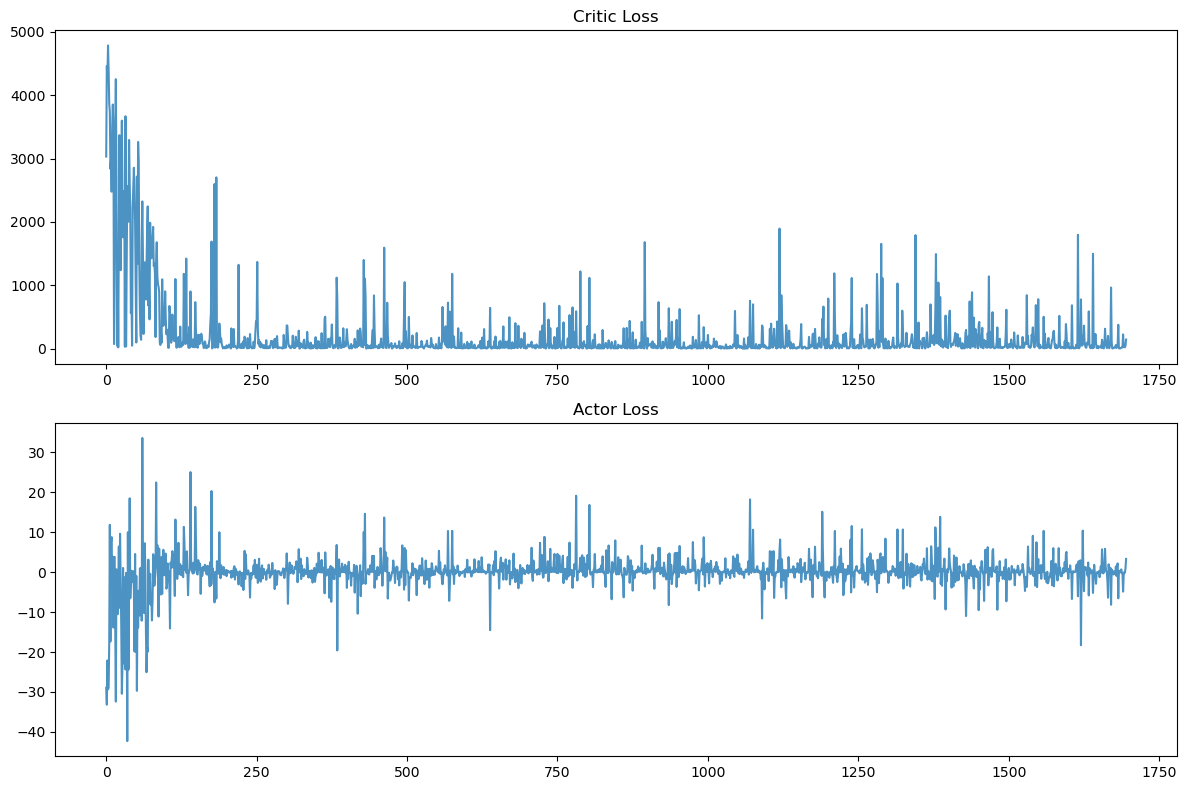

In [67]:
import matplotlib.pyplot as plt

# Assuming `losses` is a dictionary containing the loss values

# Create a figure and subplots
fig, axs = plt.subplots(2, figsize=(12, 8))

# Plot VAE loss

# Plot Critic loss
axs[0].plot(losses["critic_loss"], alpha=0.8)
axs[0].set_title("Critic Loss")

# Plot Actor loss
axs[1].plot(losses["actor_loss"], alpha=0.8)
axs[1].set_title("Actor Loss")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
batch_observations.shape

In [ ]:
batch_reconstructions.shape

In [ ]:
batch_mu.shape

In [ ]:
batch_logvar.shape

In [ ]:
batch_rewards.shape

In [ ]:
batch_log_probs.shape

In [ ]:
batch_value_preds.shape

In [ ]:
last_value_pred.shape

In [ ]:
batch_entropies.shape

In [ ]:
batch_masks.shape

In [ ]:
# max_episode_steps, 

In [ ]:
plt.plot(losses["vae_loss"])

In [ ]:
plt.plot(losses["reconstruction_loss"])

In [ ]:
plt.plot(losses["KLD_loss"])

In [ ]:
obs, info = env.reset(seed=42)

if len(obs.shape) == 4:
    obs = obs[0]

obs = transform(obs)

plt.imshow(to_np(torch.permute(obs, (1,2,0))))

In [ ]:
reconstruction, mu, logvar = vae(torch.randn(obs.shape).to(device))
plt.imshow(to_np(torch.permute(reconstruction, (1,2,0))))